# RO change over time

## Imports

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import src.XRO
import copy
import scipy.stats
import warnings

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_ensemble_fits_over_time(
    data,
    model,
    ac_mask_idx,
    T_var="T_34",
    h_var="h",
    window_size=480,
    step_size=60,
    by_ensemble_member=True,
):
    """Get RO fits for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    fits_by_year = []
    start_dates = []

    ## loop through rolling windows
    for j, i in enumerate(tqdm.tqdm(np.arange(0, n - step_size, step_size))):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            if by_ensemble_member:
                _, fits = src.utils.get_RO_ensemble(
                    data_subset,
                    T_var=T_var,
                    h_var=h_var,
                    model=model,
                    ac_mask_idx=ac_mask_idx,
                )

            else:
                with warnings.catch_warnings(action="ignore"):
                    fits = model.fit_matrix(
                        data_subset[[T_var, h_var]],
                        ac_mask_idx=ac_mask_idx,  # , maskNT=['T2', 'TH'],
                    )

            ## drop X,Y,time variables
            fits = fits.drop_vars(["X", "Y", "Yfit", "time"])
            fits_by_year.append(fits)

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    fits_by_year = xr.concat(fits_by_year, dim=start_dates)

    return fits_by_year


def update_time_coord(data, window_size=480):
    """change time coordinate to center of period used for computing stats"""

    ## get year corresponding to start of period
    year = copy.deepcopy(data.time.dt.year.values)

    ## update to midpoint of period
    year_shift = int(window_size / 12 / 2)
    year += year_shift

    ## update coordinate
    data = data.assign_coords({"time": year}).rename({"time": "year"})

    ## trim to end in 2080
    data = data.sel(year=slice(None, 2080))

    return data


def get_params(fits, model):
    """Get parameters from fits dataarray"""

    ## get parameters from fits
    params = model.get_RO_parameters(fits)

    ## get normalized noise stats
    fix_coords = lambda x: x.assign_coords({"cycle": params.cycle})
    params["xi_T_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=0))
    params["xi_h_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=1))

    return params


def get_rolling_std(data, n=20):
    """
    Get standard deviation, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    ## do the computation
    kwargs = dict(fn=np.std, n=n, reduce_ensemble_dim=False)
    data_std = src.utils.get_rolling_fn_bymonth(data, **kwargs)

    ## unstack year and month
    data_std = src.utils.unstack_month_and_year(data_std)

    return data_std

## Load data

In [3]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Compute RO parameters' change over time

### Version 1: separate RO fit for each MPI ensemble member

In [4]:
## specify save filepath
fits_save_fp = pathlib.Path(SAVE_FP / "fits_apr-30-2025.nc")

## specify args for model fit
kwargs = dict(
    T_var="T_34",
    h_var="h",
    model=src.XRO.XRO(ncycle=12, ac_order=3, is_forward=True),
    ac_mask_idx=[(1, 1)],
    window_size=480,
    step_size=60,
)


## Get fits for each period
if fits_save_fp.is_file():

    ## Load parameters if already computed
    fits = xr.open_dataset(fits_save_fp)

else:

    ## compute fits
    fits = get_ensemble_fits_over_time(Th, **kwargs)

    ## save to file
    fits.to_netcdf(fits_save_fp)

## update time coord
fits = update_time_coord(fits, window_size=kwargs["window_size"])

## extract parameters
params = get_params(fits=fits, model=kwargs["model"])

## get change from initial period
delta_params = params - params.isel(year=0)

### Version 2: single RO fit at each timestep (using all MPI ensemble members)

In [5]:
## Get fits
fits_v2 = get_ensemble_fits_over_time(Th, by_ensemble_member=False, **kwargs)

## expand "ensemble dim" to match rest of script
fits_v2 = update_time_coord(
    fits_v2.expand_dims("member"), window_size=kwargs["window_size"]
)

## extract parameters
params_v2 = get_params(fits=fits_v2, model=kwargs["model"])

## get change from initial period
delta_params_v2 = params_v2 - params_v2.isel(year=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.88it/s]


## Generate ensemble of RO parameters

In [6]:
def get_RO_sigma(model, params, ensemble_mean_params=True, **simulation_kwargs):
    """Compute stats (e.g., standard deviation) for RO parameters over time"""

    if ensemble_mean_params:
        ## use ensemble-mean parameters

        output = model.simulate(fit_ds=params.mean("member"), **simulation_kwargs)

    else:
        ## separate simulation for each parameter set

        ## empty list to hold result
        output = []

        ## loop thru ensemble members
        for i in params.member:

            ## get specs for simulation
            kwargs = dict(simulation_kwargs, fit_ds=params.sel(member=i), ncopy=1)

            ## do simulation
            output.append(model.simulate(**kwargs))

        ## concatenate output
        output = xr.concat(output, dim=params.member)

    ## remove first 5 years (spinup)
    output = output.isel(time=slice(60, None))

    return output.groupby("time.month").std()


def get_RO_sigma_over_time(
    model, params, ensemble_mean_params=True, **simulation_kwargs
):
    """Compute stats over time"""

    ## empty list to hold result
    sigmas = []

    ## loop through years
    for y in tqdm.tqdm(params.year):

        ## specs for simulation
        kwargs = dict(
            simulation_kwargs,
            model=model,
            ensemble_mean_params=ensemble_mean_params,
            params=params.sel(year=y),
        )

        ## do the simulation
        sigmas.append(get_RO_sigma(**kwargs))

    ## put back in xarray
    sigmas = xr.concat(sigmas, dim=params.year)

    return sigmas

In [7]:
## simulation specs
simulation_kwargs = dict(
    nyear=40, ncopy=50, seed=1000, X0_ds=Th[["T_34", "h"]].isel(member=0, time=0)
)

## compute with parameters estimated from all ensemble members
RO_sigma_over_time_v2 = get_RO_sigma_over_time(
    model=kwargs["model"],
    params=fits_v2,
    ensemble_mean_params=True,
    **simulation_kwargs
)

## compute with ensemble-mean parameters
RO_sigma_over_time_v3 = get_RO_sigma_over_time(
    model=kwargs["model"], params=fits, ensemble_mean_params=True, **simulation_kwargs
)


## Separate simulation for each ensemble member
ro_sigma_over_time_fp = pathlib.Path(SAVE_FP / "ro-sigma-over-time_may-21-2025.nc")
if ro_sigma_over_time_fp.is_file():

    ## Load parameters if already computed
    RO_sigma_over_time = xr.open_dataset(ro_sigma_over_time_fp)

else:

    ## compute fits
    RO_sigma_over_time = get_RO_sigma_over_time(
        model=kwargs["model"],
        params=fits,
        ensemble_mean_params=False,
        **simulation_kwargs
    )

    ## save to file
    RO_sigma_over_time.to_netcdf(ro_sigma_over_time_fp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:12<00:00,  3.34it/s]


## compute change in $\sigma(\text{Niño 3.4})$

In [8]:
## compute rolling std
Th_std = get_rolling_std(Th, n=20)

## compute percentage change in std
baseline = Th_std.isel(year=0).mean("member")
delta_Th_std = 100 * (Th_std - baseline) / baseline

### Compare MPI and RO

Function to plot results

In [9]:
def plot_stats_comp(ax, list_of_stats, labels, colors=None):
    """plot comparison of variance over time"""

    if colors is None:
        colors = sns.color_palette()[: len(list_of_stats)]

    for stats, label, c in zip(list_of_stats, labels, colors):

        ## plot median
        mplot = ax.plot(stats.year, stats["T_34"].sel(q=0.5), lw=2.5, label=label, c=c)

        ## plot lower/upper quantiles
        kwargs = dict(c=mplot[0].get_color(), lw=0.8)
        for q in stats.q:
            if q != 0.5:
                ax.plot(stats.year, stats["T_34"].sel(q=q), **kwargs)

    ## label and set plotting specs
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$\sigma_T$ ($^{\circ}$C)")
    ax.legend(prop=dict(size=8))
    ax.set_ylim([0, None])
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([0, 0.6, 1.2])

    return

Make the plot

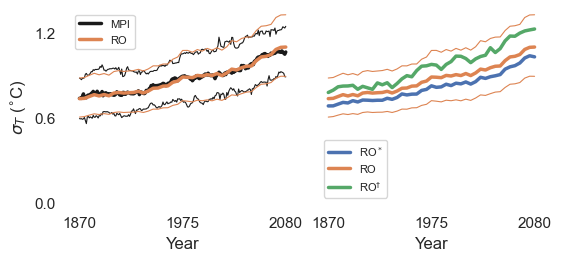

In [10]:
## specify function to reduce over months
sel_fn = lambda x: x.sel(month=8)

## specify function to compute bounds
get_stats = (
    lambda x: sel_fn(x)
    .quantile(q=[0.1, 0.5, 0.9], dim="member")
    .rename({"quantile": "q"})
)

## compute stats
stats_mpi = get_stats(Th_std)
stats_ro = get_stats(RO_sigma_over_time).sel(q=0.5).expand_dims("q")
stats_ro_v2 = get_stats(RO_sigma_over_time_v2)
stats_ro_v3 = get_stats(RO_sigma_over_time_v3).sel(q=0.5).expand_dims("q")

## plot results
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), layout="constrained")

## first, MPI vs RO
plot_stats_comp(
    axs[0],
    [stats_mpi, stats_ro_v2],
    labels=["MPI", "RO"],
    colors=["k", sns.color_palette()[1]],
)

## next, different RO methods
plot_stats_comp(
    axs[1],
    [stats_ro_v3, stats_ro_v2, stats_ro],
    labels=[r"RO$^*$", "RO", r"RO$^{\dagger}$"],
)

axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_yticks([])
axs[1].set_ylabel(None)

plt.show()

## Plot diagnostics

### Hovmoller plots for variance, growth rate, and noise

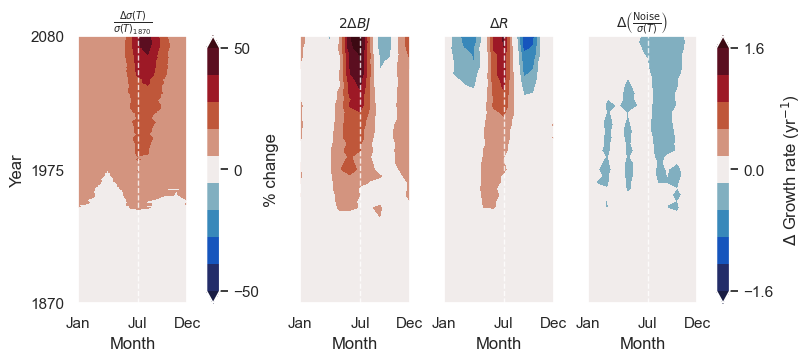

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5), layout="constrained")

#### plot change in std dev
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(50, 10), extend="both"
)

## plot data
cp0 = axs[0].contourf(
    delta_Th_std.month,
    delta_Th_std.year,
    delta_Th_std["T_34"].mean("member"),
    **plot_kwargs
)

##### plot change in model params

## specify plotting specs
plot_kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(1.5, 0.3), extend="both"
)

## plot data
cp1 = axs[1].contourf(
    params.cycle, params.year, 2 * delta_params["BJ_ac"].mean("member"), **plot_kwargs
)
cp2 = axs[2].contourf(
    params.cycle, params.year, delta_params["R"].mean("member"), **plot_kwargs
)
cp3 = axs[3].contourf(
    params.cycle, params.year, delta_params["xi_T_norm"].mean("member"), **plot_kwargs
)

## set ticks and add guideline
for ax in axs:
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)
    ax.set_xlabel("Month")

## add colorbar
cb0 = fig.colorbar(cp0, label=r"% change", ticks=[-50, 0, 50])
cb1 = fig.colorbar(cp3, label=r"$\Delta$ Growth rate (yr$^{-1}$)", ticks=[-1.6, 0, 1.6])

## label
axs[0].set_ylabel("Year")
axs[0].set_yticks([1870, 1975, 2080])
axs[0].set_title(r"$\frac{\Delta \sigma(T)}{\sigma(T)_{1870}}$", size=10)
axs[1].set_title(r"$2\Delta BJ$", size=10)
axs[2].set_title(r"$\Delta R$", size=10)
axs[3].set_title(r"$\Delta\left(\frac{\text{Noise}}{\sigma(T)}\right)$", size=10)
for ax in axs[1:]:
    ax.set_yticks([])
    ax.set_ylim(axs[0].get_ylim())

plt.show()

### Change in ensemble-mean parameters over time

Plotting funcs

In [12]:
def plot_curve(ax, x, **plot_kwargs):
    """plot change in parameter over time on given ax"""
    plot_data = ax.plot(x.year, x, lw=2, **plot_kwargs)

    return plot_data


def plot_param_change_over_time(ax, dp):
    """Plot change in parameters over time on ax object. 'dp' is change in params"""

    ## annual mean over time
    ax.axhline(0, c="k", ls="-", lw=0.5)

    ## Plot Bjerknes growth rate
    plot_curve(ax, dp["BJ_ac"].mean("cycle"), c="k", label=r"$\overline{BJ}$")
    plot_curve(ax, dp["BJ_ac"].sel(cycle=7), c="k", ls="--", label="$BJ_{Jul}$")

    ## Plot R
    R_plot = plot_curve(ax, dp["R"].mean("cycle"), label=r"$\overline{R}$")
    kwargs = dict(c=R_plot[0].get_color(), ls="--", label=r"$R_{Jul}$")
    plot_curve(ax, dp["R"].sel(cycle=7), **kwargs)

    ## plot epsilon
    plot_curve(ax, -dp["epsilon"].mean("cycle"), label=r"$-\varepsilon$")

    ## plot noise
    plot_curve(
        ax, dp["xi_T_norm"].mean("cycle"), label=r"$\xi_T/\sigma_T$", c="darkgray"
    )
    plot_curve(
        ax, dp["xi_h_norm"].mean("cycle"), label=r"$\xi_h/\sigma_h$", c="lightgray"
    )

    ## set axis specs
    ax.set_xlim([None, None])
    ax.legend(prop=dict(size=6), loc="upper left")
    ax.set_xticks([1870, 1975, 2080])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel(r"year$^{-1}$")
    ax.set_xlabel("Year")
    ax.set_title(r"$\Delta \left(\text{RO parameters}\right)$")

    return

Make plot

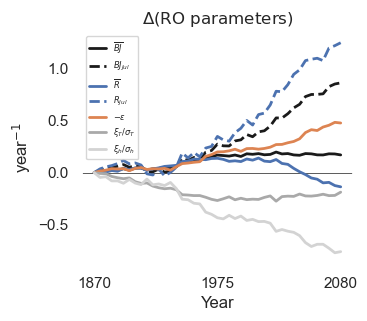

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 3))

## plot change over time of parameters
plot_param_change_over_time(ax, dp=delta_params.mean("member"))

plt.show()

#### Ensemble spread of changes

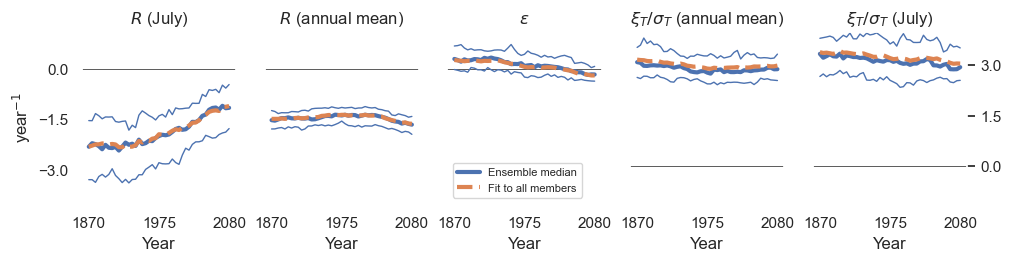

In [14]:
def plot_data(ax, sel_fn):
    """plot data on specified axis"""

    ## plot x-axis
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axhline(0, lw=0.5, ls="-", c="k")

    ## plot "mean" data
    mplot = ax.plot(
        params.year,
        sel_fn(params).quantile(q=0.5, dim="member"),
        lw=3,
        label="Ensemble median",
    )
    ax.plot(
        params.year,
        sel_fn(params_v2).squeeze(),
        lw=3,
        ls="--",
        label="Fit to all members",
    )

    ## plot bounds
    for q in [0.1, 0.9]:
        kwargs = dict(lw=1, c=mplot[0].get_color())
        ax.plot(params.year, sel_fn(params).quantile(q=q, dim="member"), **kwargs)

    ax.set_xticks([1870, 1975, 2080])
    ax.set_xlabel("Year")
    return


## set up plot
fig, axs = plt.subplots(1, 5, figsize=(10, 2.5), layout="constrained")

plot_data(axs[0], sel_fn=lambda x: x.sel(cycle=7)["R"])
plot_data(axs[1], sel_fn=lambda x: x.mean("cycle")["R"])
plot_data(axs[2], sel_fn=lambda x: x.mean("cycle")["epsilon"])
plot_data(axs[3], sel_fn=lambda x: x.mean("cycle")["xi_T_norm"])
plot_data(axs[4], sel_fn=lambda x: x.sel(cycle=7)["xi_T_norm"])

## label plots
for ax in axs[:3]:
    ax.set_ylim([-4, 1.1])

for ax in axs[3:]:
    ax.set_ylim([-1.1, 4])

axs[2].legend(prop=dict(size=8))
axs[0].set_ylabel(r"year$^{-1}$")
axs[0].set_title(r"$R$ (July)")
axs[1].set_title(r"$R$ (annual mean)")
axs[2].set_title(r"$\epsilon$")
axs[3].set_title(r"$\xi_T/\sigma_T$ (annual mean)")
axs[4].set_title(r"$\xi_T/\sigma_T$ (July)")
axs[0].set_yticks([-3, -1.5, 0])
axs[4].set_yticks([0, 1.5, 3])
axs[4].yaxis.tick_right()
# axs[4].set_ylim([2.5,3.5])

plt.show()

#### Sensitivity tests
Is noise or BJ index driving changes?

In [15]:
def get_perturbed_params(params, name):
    """get version of parameters where specified parameter
    is fixed to its starting value"""

    ## copy of params to hold perturbed values
    pparams = copy.deepcopy(params)

    ## get initial value of parameter and broadcast it to correct shape
    x0 = params[name].isel(year=0) * xr.ones_like(params[name])

    ## transpose dims to make sure they match
    x0 = x0.transpose(*params[name].dims)

    ## update parameters
    pparams[name].values = x0

    return pparams


def get_perturbed_BJ(params):
    """fix values of R and epsilon in parameter set"""

    ## initialize empty array to hold parameters
    pparams = copy.deepcopy(params)

    ## get copy of linear operator
    Lac = pparams["Lac"].transpose("year", "ranky", "rankx", ...)
    R0 = Lac.values[:1, 0, 0]
    eps0 = Lac.values[:1, 1, 1]

    ## update Lac
    Lac.values[:, 0, 0] = R0
    Lac.values[:, 1, 1] = eps0
    pparams["Lac"] = Lac

    return pparams

Get perturbed parameters and plot

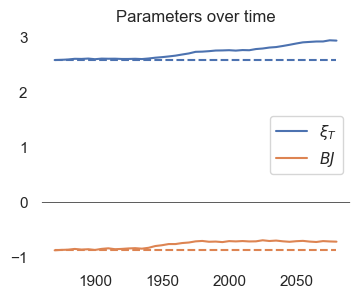

In [16]:
## get parameters with fixed noise
params_fixed_noise = get_perturbed_params(fits_v2, "xi_stdac")
params_fixed_noise = get_perturbed_params(params_fixed_noise, "xi_std")

# ## next, fix R and epsilon
params_fixed_BJ = get_perturbed_BJ(fits_v2)

## functions to extract data for plotting
sel_fn = lambda x: x.mean(["member", "cycle"])
sel_noise = lambda x: sel_fn(x)["xi_stdac"].isel(ranky=0)
sel_BJ = lambda x: kwargs["model"].get_RO_parameters(sel_fn(x))["BJ_ac"]

## set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot noise
c = sns.color_palette()[0]
ax.plot(params_fixed_noise.year, sel_noise(fits_v2), c=c, label=r"$\xi_T$")
ax.plot(params_fixed_noise.year, sel_noise(params_fixed_noise), c=c, ls="--")

## plot R
c = sns.color_palette()[1]
ax.plot(params_fixed_BJ.year, sel_BJ(fits_v2), c=c, label=r"$BJ$")
ax.plot(params_fixed_BJ.year, sel_BJ(params_fixed_BJ), c=c, ls="--")

## label
ax.legend()
ax.set_title(r"Parameters over time")
ax.axhline(0, lw=0.5, c="k")

plt.show()

Run simulations with perturbed parameters

In [17]:
## compute with parameters estimated from all ensemble members
RO_sigma_over_time_fixed_noise = get_RO_sigma_over_time(
    model=kwargs["model"],
    params=params_fixed_noise,
    ensemble_mean_params=True,
    **simulation_kwargs
)

RO_sigma_over_time_fixed_BJ = get_RO_sigma_over_time(
    model=kwargs["model"],
    params=params_fixed_BJ,
    ensemble_mean_params=True,
    **simulation_kwargs
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:12<00:00,  3.38it/s]


Plot results

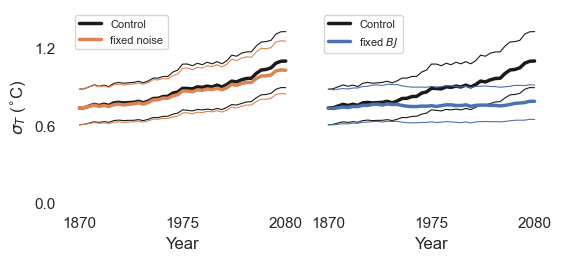

In [18]:
## specify function to reduce over months
sel_fn = lambda x: x.sel(month=8)

## specify function to compute bounds
get_stats = (
    lambda x: sel_fn(x)
    .quantile(q=[0.1, 0.5, 0.9], dim="member")
    .rename({"quantile": "q"})
)

## compute stats
stats_ro_v2 = get_stats(RO_sigma_over_time_v2)
stats_fixed_noise = get_stats(RO_sigma_over_time_fixed_noise)
stats_fixed_BJ = get_stats(RO_sigma_over_time_fixed_BJ)

## plot results
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), layout="constrained")

## first, fix noise
plot_stats_comp(
    axs[0],
    [stats_ro_v2, stats_fixed_noise, stats_fixed_BJ],
    labels=["Control", "fixed noise"],
    colors=["k", sns.color_palette()[1]],
)

## next, fix BJ
plot_stats_comp(
    axs[1],
    [stats_ro_v2, stats_fixed_BJ],
    labels=["Control", r"fixed $BJ$"],
    colors=["k", sns.color_palette()[0]],
)

axs[1].set_yticks([])
axs[1].set_ylabel(None)
for ax in axs:
    ax.set_ylim([0, 1.5])

plt.show()

### Snapshots of seasonal changes, with variance

In [15]:
def plot_mean_and_bounds(ax, x, show_bounds=True, **plot_kwargs):
    """print seasonal cycle of data in x on specified ax object"""

    ## plot ensemble mean
    plot_data = ax.plot(x.cycle, x.sel(posn="center"), lw=2, **plot_kwargs)

    ## plot bounds
    if show_bounds:
        kwargs = dict(c=plot_data[0].get_color(), ls="--", lw=0.5)
        for bound in ["upper", "lower"]:
            ax.plot(x.cycle, x.sel(posn=bound), **kwargs)

    return plot_data


def format_ax_and_twin(ax, ax_twin):
    """format ax as desired"""

    ax.set_title(y)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.set_ylim([-2, 4.7])
    ax_twin.set_ylim([0, 2.2])
    ax.set_yticks([])
    ax_twin.set_yticks([])

    return

3 panels: BJ, noise, variance

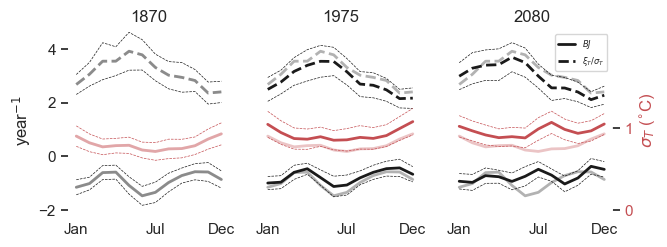

In [16]:
stats_baseline = src.utils.get_ensemble_stats(params.sel(year=1870))
var_baseline = src.utils.get_ensemble_stats(Th_std.sel(year=1870)).rename(
    {"month": "cycle"}
)

## change in params between years
fig, axs = plt.subplots(1, 3, figsize=(7, 7 / 3))

## colors for different years
colors = sns.color_palette("mako")[::2]
years = [1870, 1975, 2080]
alphas = [1 / 4, 1, 1]

axs_twin = []
for j, (y, c, a) in enumerate(zip(years, colors, alphas)):

    ## twin axis for plotting variance
    axs_twin.append(axs[j].twinx())

    ## Get stats for year
    stats = src.utils.get_ensemble_stats(params.sel(year=y))
    var_stats = src.utils.get_ensemble_stats(Th_std.sel(year=y)).rename(
        {"month": "cycle"}
    )

    ## plot baselines
    kwargs = dict(show_bounds=False, alpha=1 / 3)
    plot_mean_and_bounds(axs[j], x=stats_baseline["BJ_ac"], c="k", **kwargs)
    plot_mean_and_bounds(
        axs[j], x=stats_baseline["xi_T_norm"], c="k", ls="--", **kwargs
    )
    plot_mean_and_bounds(axs_twin[j], x=var_baseline["T_34"], c="r", **kwargs)

    ## get stats for new period
    plot_mean_and_bounds(axs[j], x=stats["BJ_ac"], c="k", alpha=a, label=r"$BJ$")
    plot_mean_and_bounds(
        axs[j], x=stats["xi_T_norm"], ls="--", c="k", alpha=a, label=r"$\xi_T/\sigma_T$"
    )
    plot_mean_and_bounds(
        axs_twin[j], x=var_stats["T_34"], c="r", alpha=a, label=r"$\sigma(T)$"
    )

    ## format axes
    format_ax_and_twin(axs[j], axs_twin[j])

axs[-1].legend(prop=dict(size=6), loc="upper right")
axs[0].set_yticks([-2, 0, 2, 4])
axs[0].set_ylabel(r"year$^{-1}$")
axs_twin[-1].set_yticks([0, 1], labels=[0, 1], color="r")
axs_twin[-1].set_ylabel(r"$\sigma_T$ ($^{\circ}$C)", color="r")

plt.show()

### Growth rate and noise vs variance

Function to format plot

In [17]:
def format_ax(ax):
    """add guidelines and labels"""
    ax.axvline(0, c="k", lw=0.5)
    ax.axhline(0, c="k", lw=0.5)
    ax.set_xticks([-0.4, 0, 0.4, 0.8])
    ax.set_yticks([0, 35, 70])
    ax.set_xlabel(r"$\Delta ~\overline{BJ}$ (year$^{-1}$)")
    ax.set_ylabel(r"$\Delta \sigma_T$ (%)")
    return

compute relative change in variance (normalize each model separately)

In [18]:
baseline = Th_std.isel(year=0)
delta_Th_std_relative = 100 * (Th_std - baseline) / baseline

Make plot

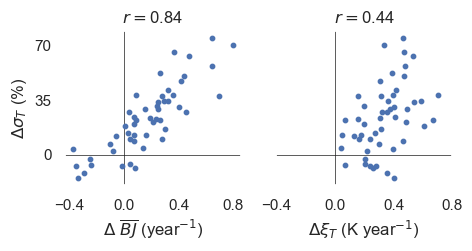

In [19]:
## get data for plot
x0 = delta_params["BJ_ac"].sel(year=2080).mean("cycle")
x1 = delta_params["xi_T"].sel(year=2080).mean("cycle")
y = delta_Th_std_relative["T_34"].sel(year=2080).mean("month")

## compute correlation
corr0, pval0 = scipy.stats.pearsonr(x0.values, y.values)
corr1, pval0 = scipy.stats.pearsonr(x1.values, y.values)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

## scatter plot preferences
scatter_kwargs = dict(zorder=10, s=10)

## plot data (BJ) and label
axs[0].scatter(x0, y, **scatter_kwargs)
axs[0].set_title(f"$r=${corr0:.2f}")
axs[0] = format_ax(axs[0])

## plot data (noise) and label
axs[1].scatter(x1, y, **scatter_kwargs)
axs[1].set_title(f"$r=${corr1:.2f}")

## label 2nd axis
format_ax(axs[1])
axs[1].set_yticks([])
axs[1].set_ylabel(None)
axs[1].set_xlabel(r"$\Delta\xi_T$ (K year$^{-1}$)")

plt.show()

## Supplementary

#### Parameter estimates from individual ensemble members

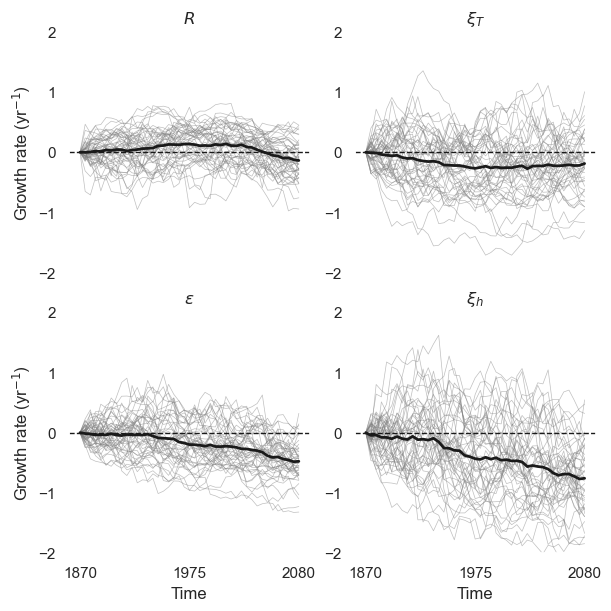

In [20]:
## param to plot
p = "epsilon"

fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout="constrained")

param_names = ["R", "xi_T_norm", "epsilon", "xi_h_norm"]
titles = [r"$R$", r"$\xi_T$", r"$\varepsilon$", r"$\xi_h$"]

for p, title, ax in zip(param_names, titles, axs.flatten()):

    ax.set_title(title)

    ## plot ensemble members
    for i, m in enumerate(params.member.values):

        label = "Ensemble members" if (i == 50) else None

        ax.plot(
            params.year,
            delta_params[p].sel(member=m).mean("cycle"),
            c="gray",
            alpha=0.5,
            lw=0.5,
        )

    ## plot ensemble mean
    ax.plot(
        params.year,
        delta_params[p].mean(["member", "cycle"]),
        c="k",
        lw=2,
        label="Ensemble mean",
    )

    ## set axis specs
    ax.set_ylim([-2, 2])
    ax.axhline(0, c="k", ls="--", lw=1)
    ax.set_xticks([])

## format
for ax in axs[1, :]:
    ax.set_xlabel("Time")
    ax.set_xticks([1870, 1975, 2080])
for ax in axs[:, 0]:
    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")

plt.show()